Let's load the datasets prepared in Part 1:

In [1]:
%%time

import pandas as pd
import numpy as np


global_variables = pd.read_csv('global_variables.csv')
train_from_part_1 = pd.read_csv('new_datasets/train_from_part_1.csv', index_col='ID_LAT_LON_YEAR_WEEK')
test_from_part_1 = pd.read_csv('new_datasets/test_from_part_1.csv', index_col='ID_LAT_LON_YEAR_WEEK')

top_three_values = train_from_part_1.loc[:, 'Location_enc'].drop_duplicates().sort_values(ascending = False).head(3)
top_three_locations = train_from_part_1.loc[train_from_part_1['Location_enc'].isin(top_three_values), 'Location'].drop_duplicates()


CPU times: total: 938 ms
Wall time: 1.55 s


In this part we'll work with the 'emission' time series, calculating trend, seasonality, cycles, etc. Therefore, we need a new method for comparing performances of our models.

We'll separate our training set from part 1 on a training and cross-validation set. Cross-validation set will include several last observations from all the Locations.

In testing a new feature, we'll first calculate this feature on a training set, then predict it on a cross-validation set and calculate cross-validation RMSE. 

If we see improvements (Cross-val RMSE goes down), then we keep the new feature.

For the submission, we'll recalculate the new feature on the whole training set and predict on the test set.

Let's divide the training set from the part 1:

In [2]:
# Calculate the proportion of test set weeks compared to the total number of weeks
proportion = len(test_from_part_1) / (len(train_from_part_1) + len(test_from_part_1))

# Calculate the desired amount of weeks in the cross-validation set
train_from_part_1_weeks = len(train_from_part_1['WeekCount'].unique())
cv_weeks = round(train_from_part_1_weeks * proportion)
train_weeks = train_from_part_1_weeks - cv_weeks
test_weeks = len(test_from_part_1['WeekCount'].unique())

print('Weeks in the training set: {}'.format(train_weeks))
print('Weeks in the cross-validation set: {}'.format(cv_weeks))
print('Weeks in the test set: {}'.format(test_weeks))

# Create training and cross-validation sets
train = pd.DataFrame(train_from_part_1.loc[train_from_part_1['WeekCount'] < train_weeks, ['Location', 'WeekCount', 'emission']])
cv = pd.DataFrame(train_from_part_1.loc[train_from_part_1['WeekCount'] >= train_weeks, ['Location', 'WeekCount', 'emission']])

print("The last 5 rows of the cross-validation set:")
cv.tail()

Weeks in the training set: 122
Weeks in the cross-validation set: 37
Weeks in the test set: 49
The last 5 rows of the cross-validation set:


,Location,Location_enc,WeekCount,emission
ID_LAT_LON_YEAR_WEEK,,,,
ID_-3.299_30.301_2021_48,-3.29930.301,28.150387,154,29.404171
ID_-3.299_30.301_2021_49,-3.29930.301,28.150387,155,29.186497
ID_-3.299_30.301_2021_50,-3.29930.301,28.150387,156,29.131205
ID_-3.299_30.301_2021_51,-3.29930.301,28.150387,157,28.125792
ID_-3.299_30.301_2021_52,-3.29930.301,28.150387,158,27.239302


## 00. Baseline

We'll use a separate scores DataFrame in this part, with RMSE as our scores. Let's calculate a new baseline, where emissions will be just the median emissions (calculated on the training set):

In [3]:
study_number = '00'

from sklearn.metrics import mean_squared_error


# Calculate train and cv RMSE
score_train = mean_squared_error(train['emission'], [train['emission'].median()] * len(train), squared=False)
score_cv = mean_squared_error(cv['emission'], [train['emission'].median()] * len(cv), squared=False)

# Create a submission file (median emissions calculated on the whole available data)
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test_from_part_1.index, \
                           'emission': [train_from_part_1['emission'].median()] * len(test_from_part_1)})

submission.to_csv('submissions/submission_2_' + study_number + '.csv', index=False)


In [4]:
# Create scores DataFrame
scores_df = pd.DataFrame({'Comment': [], 'Train RMSE': [], 'Cross-val RMSE': [], 'Test RMSE': []})

# Write down the scores
scores_df.loc[int(study_number), 'Comment'] = 'Just Median'
scores_df.loc[int(study_number), 'Train RMSE'] = score_train
scores_df.loc[int(study_number), 'Cross-val RMSE'] = score_cv
scores_df.loc[int(study_number), 'Test RMSE'] = 175.20974

scores_df

,Comment,Train RMSE,Cross-val RMSE,Test RMSE
0,Just Median,150.370895,144.13248,175.20974


## Exploring time series

Let's look at the 'emission' time series for every location that has median emissions above 95th quantile:

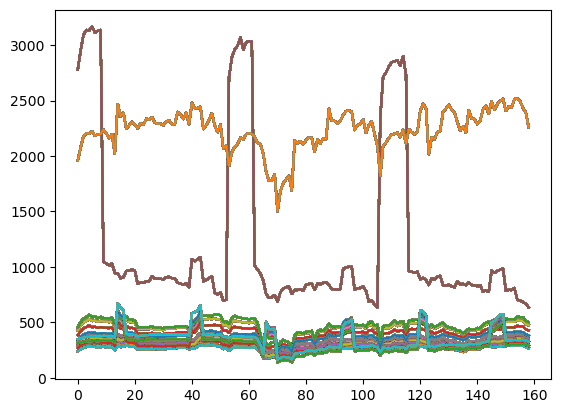

CPU times: total: 2.86 s
Wall time: 4.53 s


In [5]:
%%time

quantile = train_from_part_1['emission'].quantile(0.95)

import matplotlib.pyplot as plt

for location in train_from_part_1.loc[train_from_part_1['Location_enc'] > quantile, 'Location']:
    series = train_from_part_1.loc[train_from_part_1['Location'] == location, 'emission']
    plt.plot(range(len(series)), series)
plt.show()

We can see a few things here:

-) There seems to be a common trend

-) Sesonality is similar for most of the locations, except for the two with the highest emissions.

## 01. Common trend

Let's look at the median emissions time series across all locations:

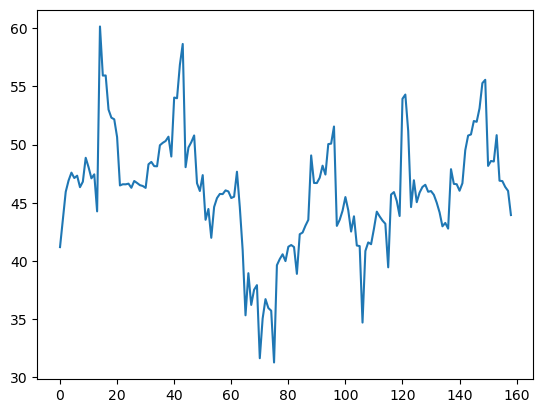

In [6]:
study_number = '01'

plt.plot(range(train_from_part_1_weeks), train_from_part_1.groupby('WeekCount')['emission'].median())
plt.show()

Let's calculate a common trend on the traning set:

In [7]:
%%time

from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression

# Calculate trend on the training set
dp = DeterministicProcess(index=range(train_weeks), constant=True, order=2, drop=True)
X = dp.in_sample()
y = train.groupby('WeekCount')['emission'].median()

lr = LinearRegression(fit_intercept=False)
lr.fit(X, y)

y_train_pred = pd.Series(lr.predict(X), index=X.index)

train['CommonTrend'] = train['WeekCount'].map(y_train_pred)

# Continue trend on the cv set:

X = dp.out_of_sample(steps=49)

y_cv_pred = pd.Series(lr.predict(X), index=X.index)

cv['CommonTrend'] = cv['WeekCount'].map(y_cv_pred)

CPU times: total: 31.2 ms
Wall time: 93.6 ms


Let's look at the trend:

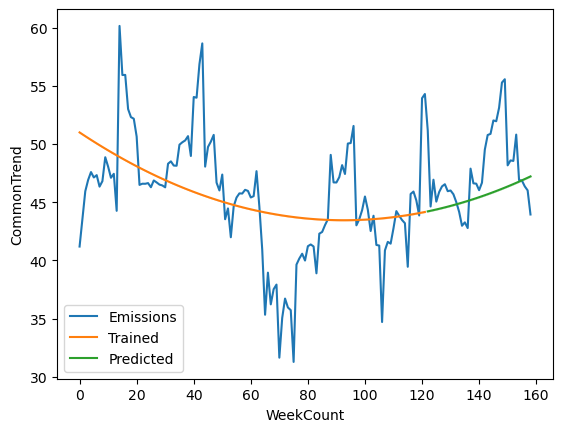

CPU times: total: 3.84 s
Wall time: 4.8 s


In [8]:
%%time

import seaborn as sns
ax = plt.plot(range(train_from_part_1_weeks), train_from_part_1.groupby('WeekCount')['emission'].median(), label='Emissions')
sns.lineplot(data = train, x='WeekCount', y='CommonTrend', label='Trained')
sns.lineplot(data = cv, x='WeekCount', y='CommonTrend', label='Predicted')
plt.legend()

plt.show()

Let's calculate the errors:

In [9]:
# Calculate scores
score_train = mean_squared_error(train['emission'], train['CommonTrend'], squared=False)
score_cv = mean_squared_error(cv['emission'], cv['CommonTrend'], squared=False)


# Write down the scores
scores_df.loc[int(study_number), 'Comment'] = 'CommonTrend'
scores_df.loc[int(study_number), 'Train RMSE'] = score_train
scores_df.loc[int(study_number), 'Cross-val RMSE'] = score_cv
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan

scores_df

,Comment,Train RMSE,Cross-val RMSE,Test RMSE
0,Just Median,150.370895,144.132480,175.20974
1,CommonTrend,150.222710,143.983918,NaN


Cross-val RMSE has decreased a bit, but not much. For simplicity, I suggest to not use the common trend.

## 02. Trend

Let's calculate a trend for each location. As we could see in the first plot in this notebook, there is one special location, that has a linear trend. We'll calulcate the trend for this location separately. For all the others we'll use a quadratic trend.

In [45]:
%%time

study_number = '02'

from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression

for location in train['Location'].unique():
    # Calculate trend on the training set
    dp = DeterministicProcess(index=train[train['Location'] == location].index, constant=True, order=2, drop=True)
    X = dp.in_sample()
    y = train.loc[train['Location'] == location, 'emission']

    lr = LinearRegression(fit_intercept=False)
    lr.fit(X, y)

    y_pred = pd.Series(lr.predict(X), index=X.index)
    
    train.loc[y_pred.index, 'Trend'] = y_pred
    
    # Continue trend on the cv set:
    X = dp.out_of_sample(steps=cv_weeks)
    
    y_pred = pd.Series(lr.predict(X), index=cv[cv['Location'] == location].index)
    
    cv.loc[y_pred.index, 'Trend'] = y_pred

    
    
## For the special location - linear trend
special_location = top_three_locations[1]

location = special_location
# Calculate trend on the training set
dp = DeterministicProcess(index=train[train['Location'] == location].index, constant=True, order=1, drop=True)
X = dp.in_sample()
y = train.loc[train['Location'] == location, 'emission']

lr = LinearRegression(fit_intercept=False)
lr.fit(X, y)

y_pred = pd.Series(lr.predict(X), index=X.index)

train.loc[y_pred.index, 'Trend'] = y_pred

# Continue trend on the cv set:
X = dp.out_of_sample(steps=cv_weeks)

y_pred = pd.Series(lr.predict(X), index=cv[cv['Location'] == location].index)

cv.loc[y_pred.index, 'Trend'] = y_pred



C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


CPU times: total: 26.5 s
Wall time: 8.21 s


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


Let's look at the trend example for the 3 Locations with the highest median emissions:

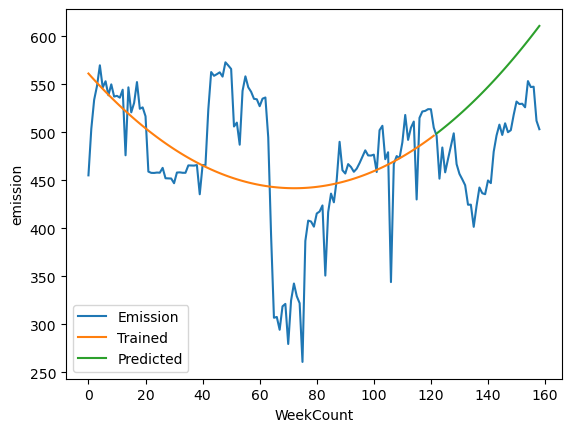

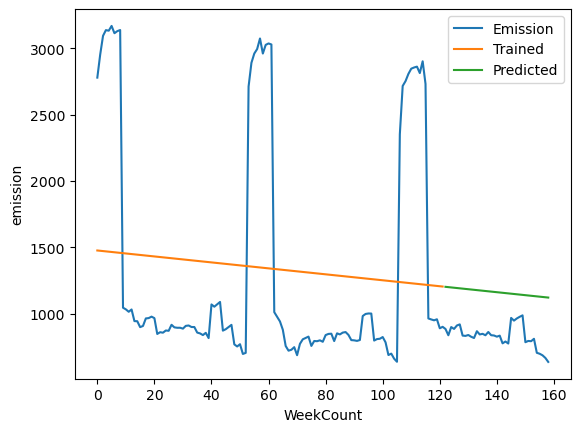

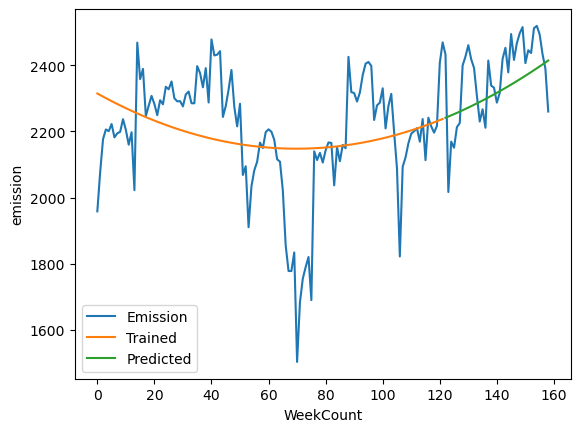

CPU times: total: 547 ms
Wall time: 620 ms


In [46]:
%%time

for location in top_three_locations:

    sns.lineplot(data = train_from_part_1[train_from_part_1['Location'] == location], x='WeekCount', y='emission', label='Emission')
    sns.lineplot(data = train[train['Location'] == location], x='WeekCount', y='Trend', label='Trained')
    sns.lineplot(data = cv[cv['Location'] == location], x='WeekCount', y='Trend', label='Predicted')
    plt.legend()
    plt.show()


Let's calculate the errors:

In [47]:
# Calculate scores
score_train = mean_squared_error(train['emission'], train['Trend'], squared=False)
score_cv = mean_squared_error(cv['emission'], cv['Trend'], squared=False)


# Write down the scores
scores_df.loc[int(study_number), 'Comment'] = 'Trend'
scores_df.loc[int(study_number), 'Train RMSE'] = score_train
scores_df.loc[int(study_number), 'Cross-val RMSE'] = score_cv
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan

scores_df

,Comment,Train RMSE,Cross-val RMSE,Test RMSE
0,Just Median,150.370895,144.132480,175.20974
1,CommonTrend,150.222710,143.983918,NaN
2,Trend,47.029818,30.359811,NaN


Good, that worked. Now we have to do the following steps:

-) Recalculate trends on the whole available data

-) Predict for the test set

-) (optional) Make a submission and look at the Test RMSE

-) Create a new feature, 'emission_02' (where 02 is the current chapter number, not the part number). This feature will be equal to 'emission' - 'Trend', i.e, detrended 'emission', and in the next step we'll be using this feature as our new target.

Let's start:

In [55]:
# Prepare a new test DataFrame with new features
test = pd.DataFrame(test_from_part_1.loc[:, ['Location', 'WeekCount']])


# Recalculate trends on the whole available data
for location in train['Location'].unique():
    dp = DeterministicProcess(index=train_from_part_1[train_from_part_1['Location'] == location].index, constant=True, order=2, drop=True)
    X = dp.in_sample()
    y = train_from_part_1.loc[train_from_part_1['Location'] == location, 'emission']

    lr = LinearRegression(fit_intercept=False)
    lr.fit(X, y)
    
    y_pred = pd.Series(lr.predict(X), index=X.index)
    
    # Break the calculated trend on a train and cv parts
    y_pred_train = y_pred[: len(train) - 1]
    y_pred_cv = y_pred[len(train): ]
    
    train.loc[y_pred_cv.index, 'Trend'] = y_pred_cv
    cv.loc[y_pred_cv.index, 'Trend'] = y_pred_cv
    
    # Continue trend on the test set:
    
    X = dp.out_of_sample(steps=test_weeks)
    
    y_pred = pd.Series(lr.predict(X), index=test_from_part_1[test_from_part_1['Location'] == location].index)
    
    test.loc[y_pred.index, 'Trend'] = y_pred
    

## For the special location - linear trend
location = special_location

dp = DeterministicProcess(index=train_from_part_1[train_from_part_1['Location'] == location].index, constant=True, order=1, drop=True)
X = dp.in_sample()
y = train_from_part_1.loc[train_from_part_1['Location'] == location, 'emission']

lr = LinearRegression(fit_intercept=False)
lr.fit(X, y)

y_pred = pd.Series(lr.predict(X), index=X.index)

# Break the calculated trend on a train and cv parts
y_pred_train = y_pred[: len(train) - 1]
y_pred_cv = y_pred[len(train): ]

train.loc[y_pred_cv.index, 'Trend'] = y_pred_cv
cv.loc[y_pred_cv.index, 'Trend'] = y_pred_cv

# Continue trend on the test set:

X = dp.out_of_sample(steps=test_weeks)

y_pred = pd.Series(lr.predict(X), index=test_from_part_1[test_from_part_1['Location'] == location].index)

test.loc[y_pred.index, 'Trend'] = y_pred


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


Let's look at the trend example for one of the locations:

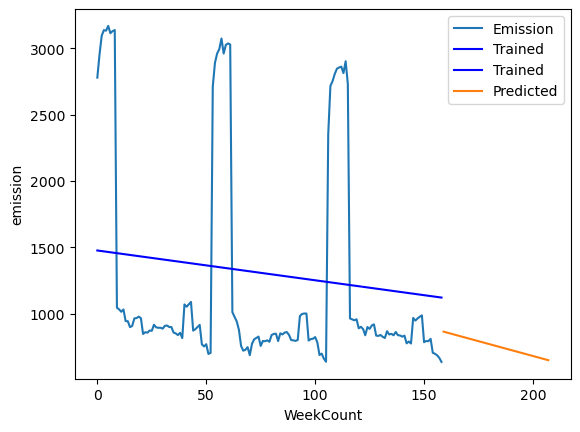

CPU times: total: 578 ms
Wall time: 233 ms


In [56]:
%%time

sns.lineplot(data = train_from_part_1[train_from_part_1['Location'] == special_location], x='WeekCount', y='emission', label='Emission')
sns.lineplot(data = train[train['Location'] == special_location], x='WeekCount', y='Trend', label='Trained', c='b')
sns.lineplot(data = cv[cv['Location'] == special_location], x='WeekCount', y='Trend', label='Trained', c='b')
sns.lineplot(data = test[test['Location'] == special_location], x='WeekCount', y='Trend', label='Predicted')
plt.legend()
plt.show()

Let's make a submission and look at the Test RMSE:

In [57]:
# Create a submission file (median emissions calculated on the whole available data)
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test_from_part_1.index, \
                           'emission': test['Trend']})

submission.to_csv('submissions/submission_2_' + study_number + '.csv', index=False)

In [58]:
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan

scores_df

,Comment,Train RMSE,Cross-val RMSE,Test RMSE
0,Just Median,150.370895,144.132480,175.20974
1,CommonTrend,150.222710,143.983918,NaN
2,Trend,47.029818,30.359811,NaN


Let's create the detrended feature:

In [59]:
for data in [train, cv]:
    data['emission_' + study_number] = data['emission'] - data['Trend']
    
train.head()

,Location,Location_enc,WeekCount,emission,CommonTrend,Trend,emission_02
ID_LAT_LON_YEAR_WEEK,,,,,,,
ID_-0.510_29.290_2019_00,-0.5129.29,4.327319,0,3.750994,50.995863,4.495939,-0.744945
ID_-0.510_29.290_2019_01,-0.5129.29,4.327319,1,4.025176,50.833865,4.485820,-0.460643
ID_-0.510_29.290_2019_02,-0.5129.29,4.327319,2,4.231381,50.673625,4.475831,-0.244450
ID_-0.510_29.290_2019_03,-0.5129.29,4.327319,3,4.305286,50.515145,4.465972,-0.160686
ID_-0.510_29.290_2019_04,-0.5129.29,4.327319,4,4.347317,50.358424,4.456243,-0.108926


## 03. Seasonality

Let's look at the 'emission_02' time series for every location that has median emissions above 99th quantile:

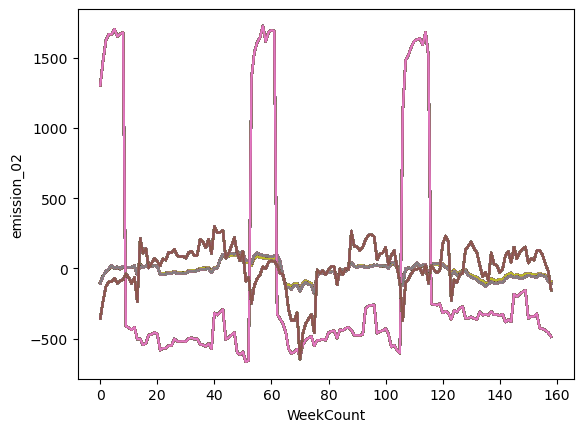

CPU times: total: 9.58 s
Wall time: 11.7 s


In [61]:
%%time



quantile = train_from_part_1['emission'].quantile(0.99)

for location in train_from_part_1.loc[train_from_part_1['Location_enc'] > quantile, 'Location']:
    sns.lineplot(data=pd.concat([train[train['Location'] == location], cv[cv['Location'] == location]]), x='WeekCount', y='emission_02')
    #sns.lineplot(data=cv[cv['Location'] == location], x='WeekCount', y='emission_02')
#     series = train.loc[train['Location'] == location, 'emission_02']
#     plt.plot(range(len(series)), series)
#     series_2 = cv.loc[cv['Location'] == location, 'emission_02']
#     plt.plot(range(len(series), len(series_2)), series_2)
plt.show()